In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
train_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-training-dataset.csv')
test_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-test-dataset.csv')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


gender
male      6833
female    5778
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='count'>

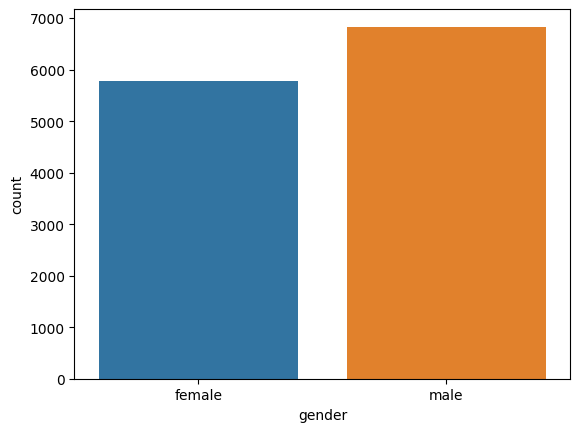

In [5]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [6]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  female    1.279181
1  1378.png       12  False  female   -2.800269
2  1379.png       94  False  female   -0.809109
3  1380.png      120   True    male   -0.177766
4  1381.png       82  False  female   -1.100498


Text(0.5, 1.0, 'Number of children in each age group')

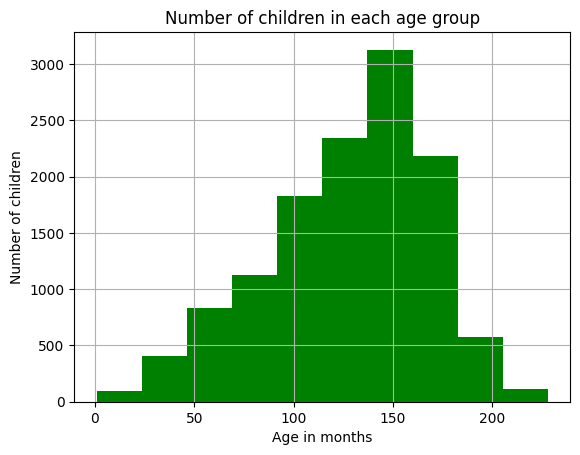

In [7]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')


Text(0.5, 1.0, 'Relationship between number of children and bone age z score')

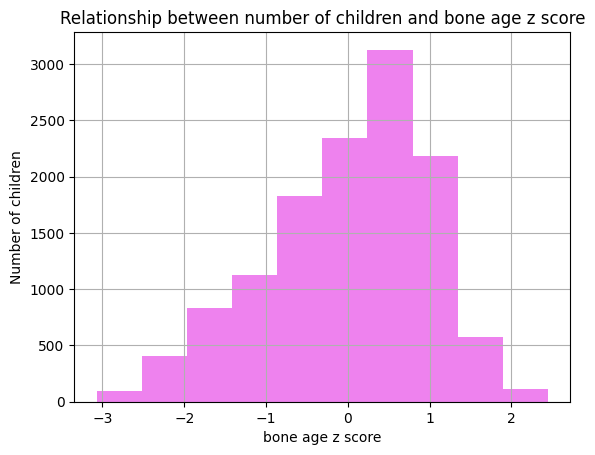

In [8]:
train_df['bone_age_z'].hist(color = 'violet')
plt.xlabel('bone age z score')
plt.ylabel('Number of children')
plt.title('Relationship between number of children and bone age z score')

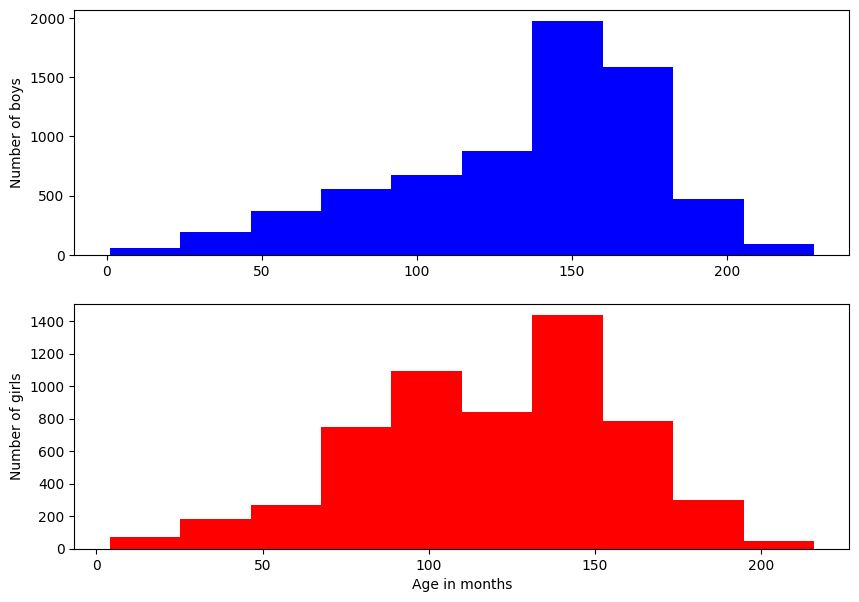

In [9]:
#distribution of age within each gender 
male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('Number of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of girls')
fig.set_size_inches((10,7))

In [10]:
#splitting train dataframe into traininng and validation dataframes
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

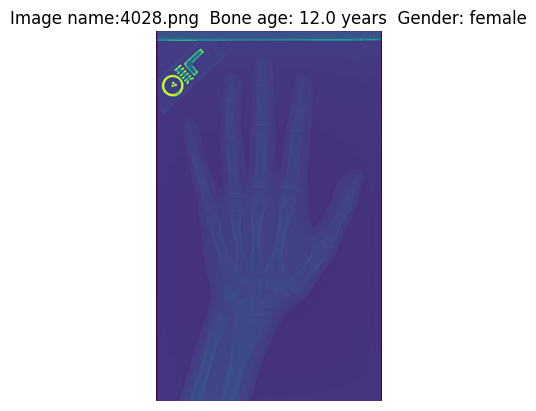

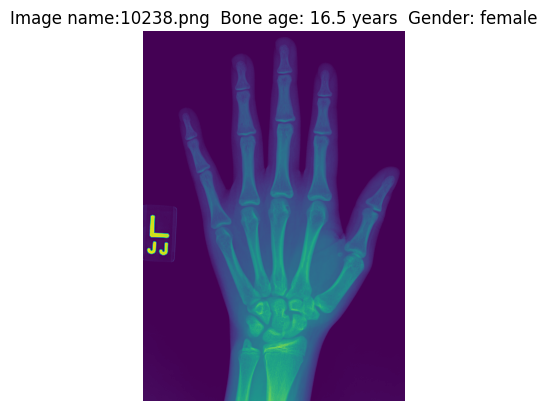

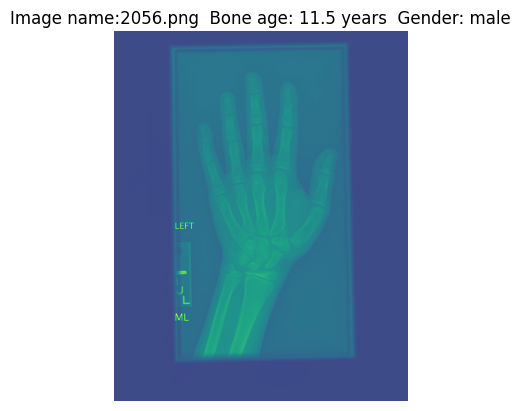

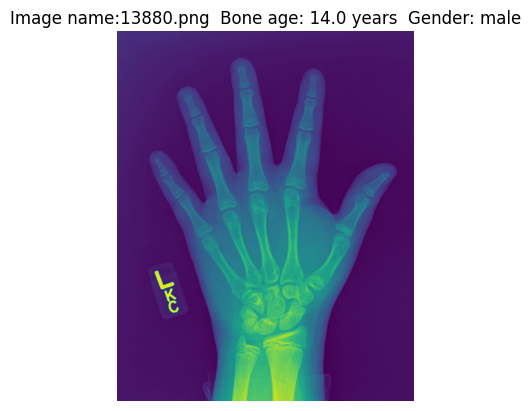

In [11]:
import matplotlib.image as mpimg
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(4).values:
    img = mpimg.imread('/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/'+ filename)
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender))
    plt.axis('off')
    plt.show()

In [12]:
#library required for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

#reducing down the size of the image 
img_size = 256

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = '/kaggle/input/rsna-bone-age/boneage-test-dataset',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 10088 validated image filenames.
Found 2523 validated image filenames.
Found 200 images belonging to 1 classes.


In [13]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'other'
                            )) 

Found 2523 validated image filenames.


In [14]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [15]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [16]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Sequential
import tensorflow as tf

# Load Xception model without the top (final dense layers)
model_1 = tf.keras.applications.Xception(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights=None  # Set to None since you'll load weights manually
)

# Load the pre-trained weights from your uploaded file
weights_path = '/kaggle/input/dowload/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
model_1.load_weights(weights_path)

# Set the model as trainable (so that we can fine-tune)
model_1.trainable = True

# Create a Sequential model
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(10, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Compile the model
model_2.compile(loss='mse', optimizer='adam', metrics=[mae_in_months])

# Show the model summary
model_2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [17]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_dir = '.\logs'
%tensorboard --logdir {logs_dir}

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729775718.078566      87 service.cc:145] XLA service 0x787a200022d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729775718.078617      87 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729775718.078621      87 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729775754.066093      87 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_470', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1729775754.098311 

 59/315 ━━━━━━━━━━━━━━━━━━━━ 6:14 1s/step - loss: 1.8424 - mae_in_months: 40.4622

I0000 00:00:1729775861.182128      86 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 112 bytes spill stores, 112 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 80 bytes spill stores, 80 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 112 bytes spill stores, 112 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 88 bytes spill stores, 88 bytes spill loads



315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.9668 - mae_in_months: 29.4119

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


315/315 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - loss: 0.9654 - mae_in_months: 29.3871 - val_loss: 0.2142 - val_mae_in_months: 14.7888 - learning_rate: 0.0010
Epoch 2/50
  1/315 ━━━━━━━━━━━━━━━━━━━━ 2:55 559ms/step - loss: 0.1704 - mae_in_months: 14.1063

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1704 - mae_in_months: 14.1063 - val_loss: 0.3044 - val_mae_in_months: 15.9859 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - loss: 0.1647 - mae_in_months: 13.2069 - val_loss: 0.1601 - val_mae_in_months: 13.7103 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1403 - mae_in_months: 12.4208 - val_loss: 0.2007 - val_mae_in_months: 15.1341 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - loss: 0.1115 - mae_in_months: 10.7859 - val_loss: 0.1989 - val_mae_in_months: 14.1075 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0577 - mae_in_months: 8.7537 - val_loss: 0.2180 - val_mae_in_months: 15.4700 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 322s 999ms/step - loss: 0.0849 - mae_in_months: 9.4533 - val_loss: 0.3560 - val_mae_in_months: 20.2599 - learning_rate: 0.0010
Epoch 8/50
315/315 ━

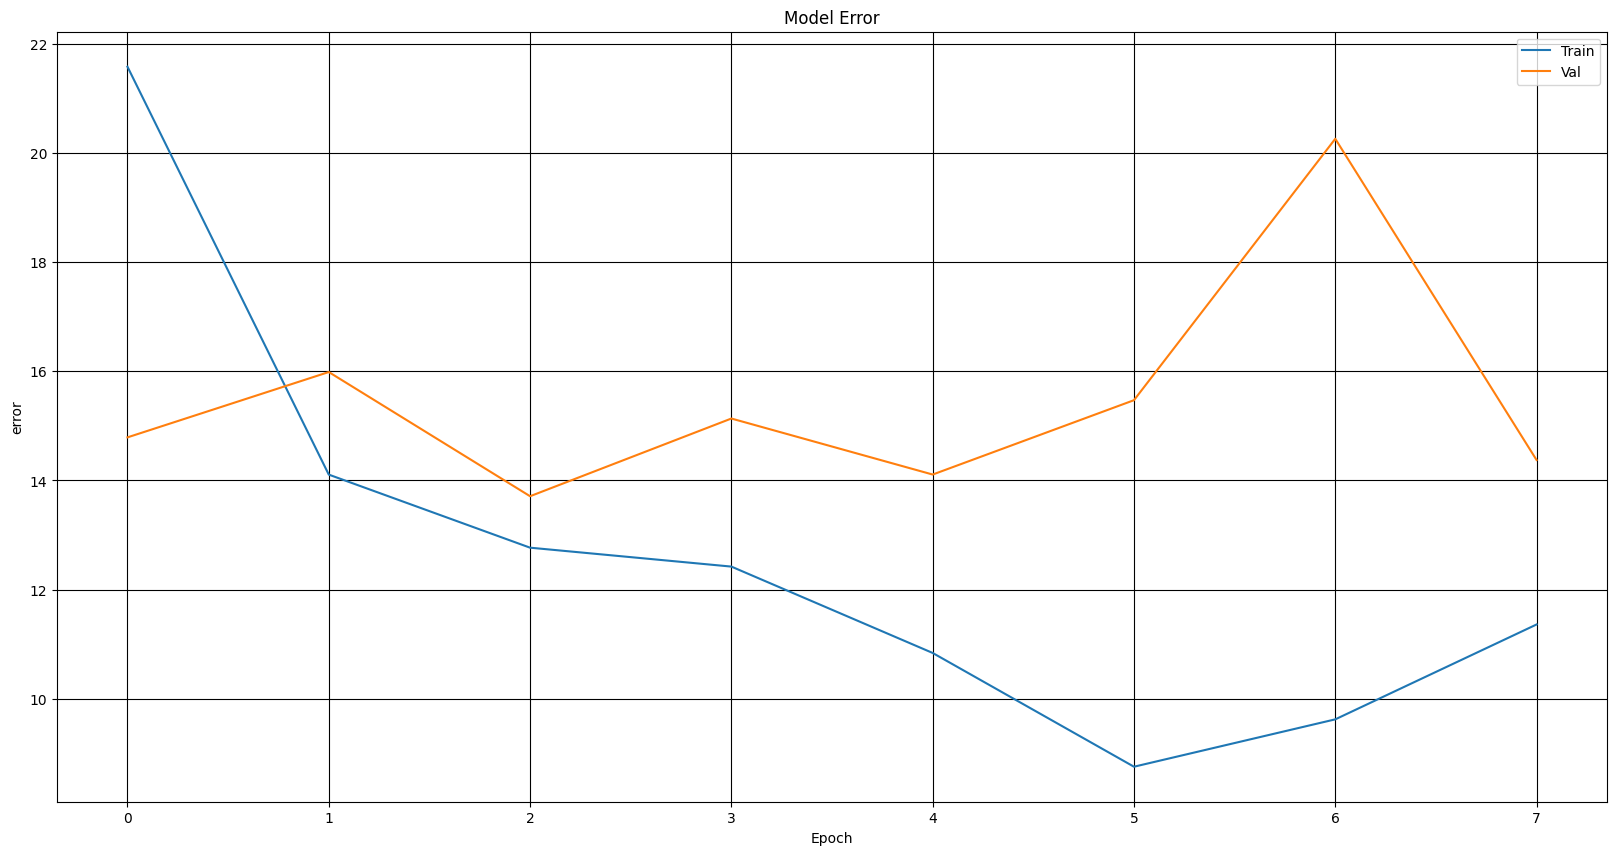

In [18]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

# Model checkpoint
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

# TensorBoard callback
logdir = os.path.join(logs_dir, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

# Reduce learning rate on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', 
                                min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks = [tensorboard_callback, early_stopping, mc, red_lr_plat]

# Fit the model
history = model_2.fit(train_generator,
                      steps_per_epoch=315,
                      validation_data=val_generator,
                      validation_steps=1,
                      epochs=50,
                      callbacks=callbacks)

# Start TensorBoard
%tensorboard --logdir logs

# Plot the training history
plot_it(history)


79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step


/tmp/ipykernel_29/2450852891.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0,


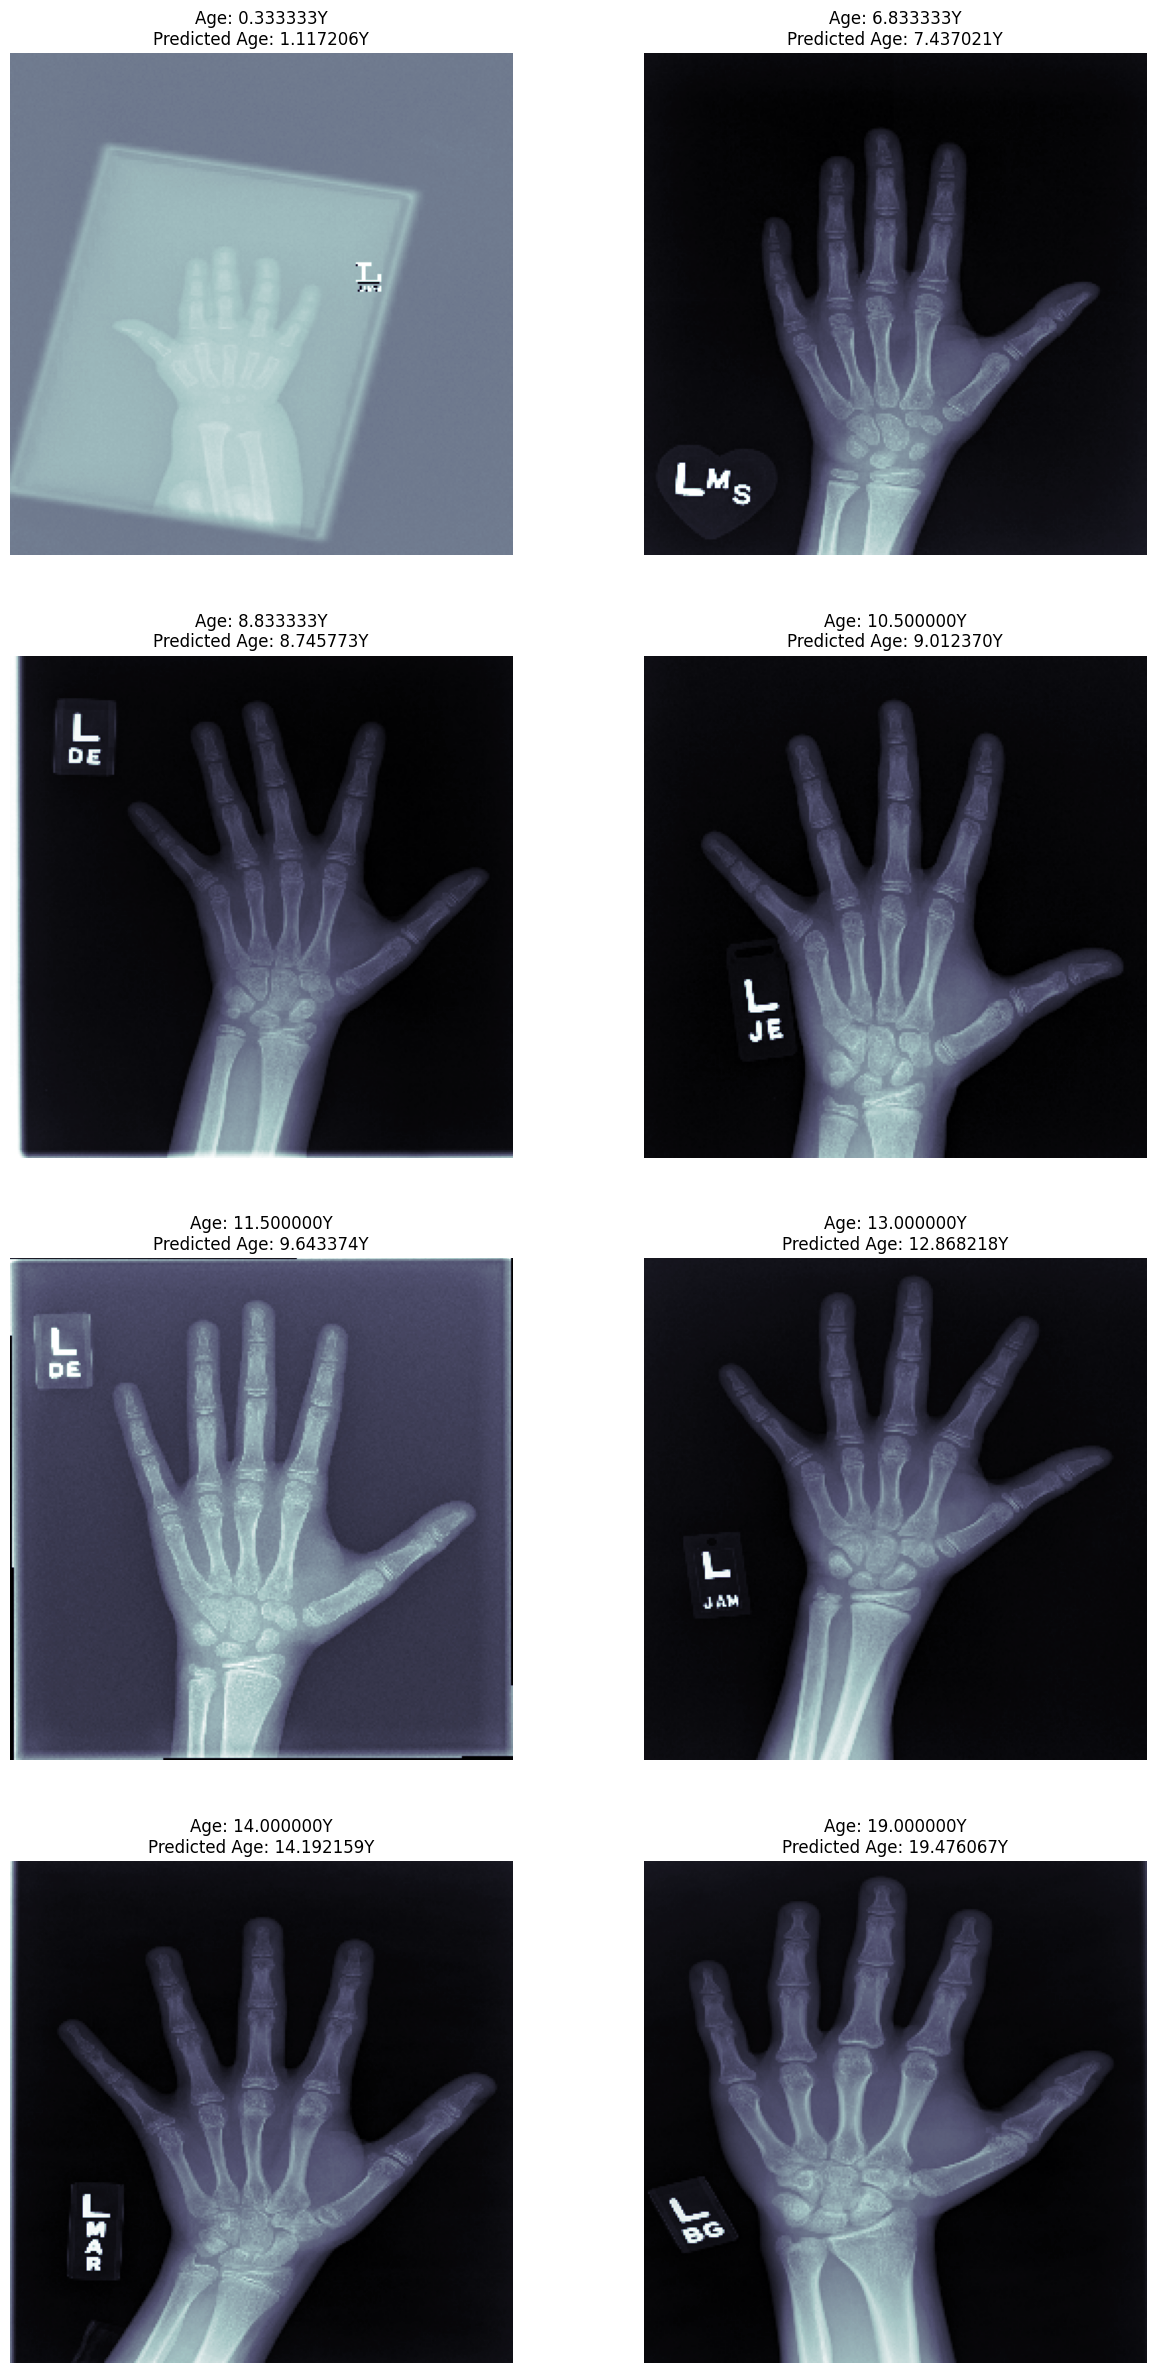

In [20]:
model_2.load_weights('best_model.keras')
pred = mean_bone_age + std_bone_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)